# Demonstrate energy ratio options

The purpose of this notebook is to show some options in calculation of energy ratio

In [12]:
from pathlib import Path

import floris.layout_visualization as layoutviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from floris import FlorisModel, TimeSeries

from flasc.analysis import energy_ratio as erp
from flasc.analysis.energy_ratio_input import EnergyRatioInput
from flasc.data_processing import dataframe_manipulations as dfm

# Generate dataset with FLORIS

Use FLORIS to make a simple data set consisting of 4 turbines in a box, winds from the west, turbine 0/1 upstream, turbine 2/3 downstream

Text(0, 0.5, 'y coordinate [m]')

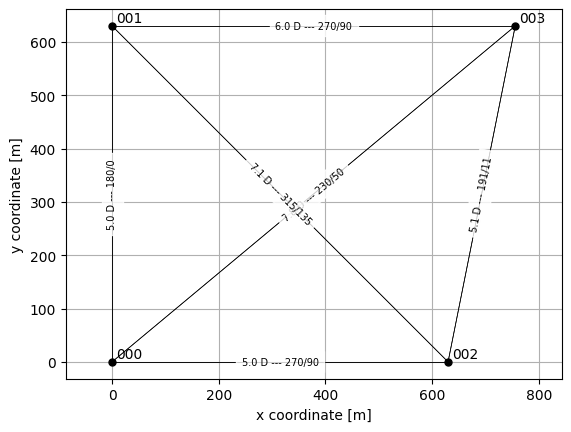

In [13]:
file_path = Path.cwd()
fm_path = file_path / "../floris_input_artificial/gch.yaml"
fm = FlorisModel(fm_path)
fm.set(layout_x=[0, 0, 5 * 126, 6 * 126], layout_y=[0, 5 * 126, 0, 5 * 126])

# # Show the wind farm
ax = layoutviz.plot_turbine_points(fm)
layoutviz.plot_turbine_labels(fm, ax=ax)
layoutviz.plot_waking_directions(fm, ax=ax)
ax.grid()
ax.set_xlabel("x coordinate [m]")
ax.set_ylabel("y coordinate [m]")

Num Points 500


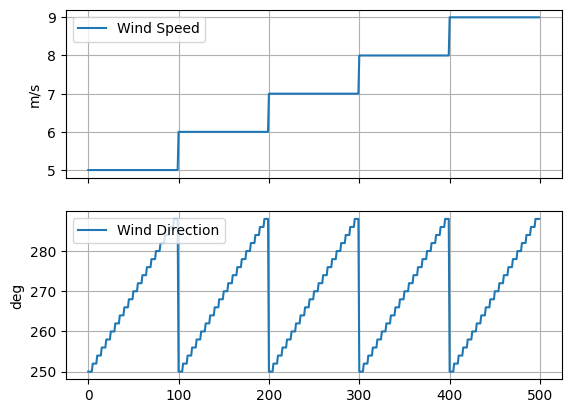

In [14]:
# Create a time history of points where the wind
# speed and wind direction step different combinations
ws_points = np.arange(5.0, 10.0, 1.0)
wd_points = np.arange(
    250.0,
    290.0,
    2,
)
num_points_per_combination = 5  # How many "seconds" per combination

# I know this is dumb but will come back, can't quite work out the numpy version
ws_array = []
wd_array = []
for ws in ws_points:
    for wd in wd_points:
        for i in range(num_points_per_combination):
            ws_array.append(ws)
            wd_array.append(wd)
t = np.arange(len(ws_array))
wd_array = np.array(wd_array)
ws_array = np.array(ws_array)

print(f"Num Points {len(t)}")

fig, axarr = plt.subplots(2, 1, sharex=True)
axarr[0].plot(t, ws_array, label="Wind Speed")
axarr[0].set_ylabel("m/s")
axarr[0].legend()
axarr[0].grid(True)
axarr[1].plot(t, wd_array, label="Wind Direction")
axarr[1].set_ylabel("deg")
axarr[1].legend()
axarr[1].grid(True)

In [15]:
# Compute the power of the second turbine for two cases
# Baseline: The front turbine is aligned to the wind
# WakeSteering: The front turbine is yawed 25 deg
fm.set(
    wind_data=TimeSeries(
        wind_directions=wd_array, wind_speeds=ws_array, turbulence_intensities=0.06
    )
)
fm.run()

# Collect the turbine powers
power_0 = fm.get_turbine_powers()[:, 0].flatten() / 1000.0
power_1 = fm.get_turbine_powers()[:, 1].flatten() / 1000.0
power_2 = fm.get_turbine_powers()[:, 2].flatten() / 1000.0
power_3 = fm.get_turbine_powers()[:, 3].flatten() / 1000.0

# Assume all turbine measure wind direction with some noise
wd_0 = wd_array + np.random.randn(len(wd_array)) * 2
wd_1 = wd_array + np.random.randn(len(wd_array)) * 2
wd_2 = wd_array + np.random.randn(len(wd_array)) * 2
wd_3 = wd_array + np.random.randn(len(wd_array)) * 2

# Only collect the wind speeds of the upstream turbines
ws_0 = ws_array + np.random.randn(len(wd_array)) * 1
ws_1 = ws_array + np.random.randn(len(wd_array)) * 1

In [16]:
# Now build the dataframe
df = pd.DataFrame(
    {
        "pow_000": power_0,
        "pow_001": power_1,
        "pow_002": power_2,
        "pow_003": power_3,
        "ws_000": ws_0,
        "ws_001": ws_1,
        "wd_000": wd_0,
        "wd_001": wd_1,
        "wd_002": wd_2,
        "wd_003": wd_3,
    }
)

In [17]:
# Build the energy ratio input
er_in = EnergyRatioInput([df], ["baseline"], num_blocks=10)

array([<Axes: title={'center': 'Energy Ratio'}, ylabel='Energy Ratio'>,
       <Axes: title={'center': 'Number of Points per Bin'}, ylabel='Number of Points'>,
       <Axes: title={'center': 'Minimum Number of Points per Bin'}, xlabel='Wind Direction (deg)', ylabel='Wind Speed (m/s)'>],
      dtype=object)

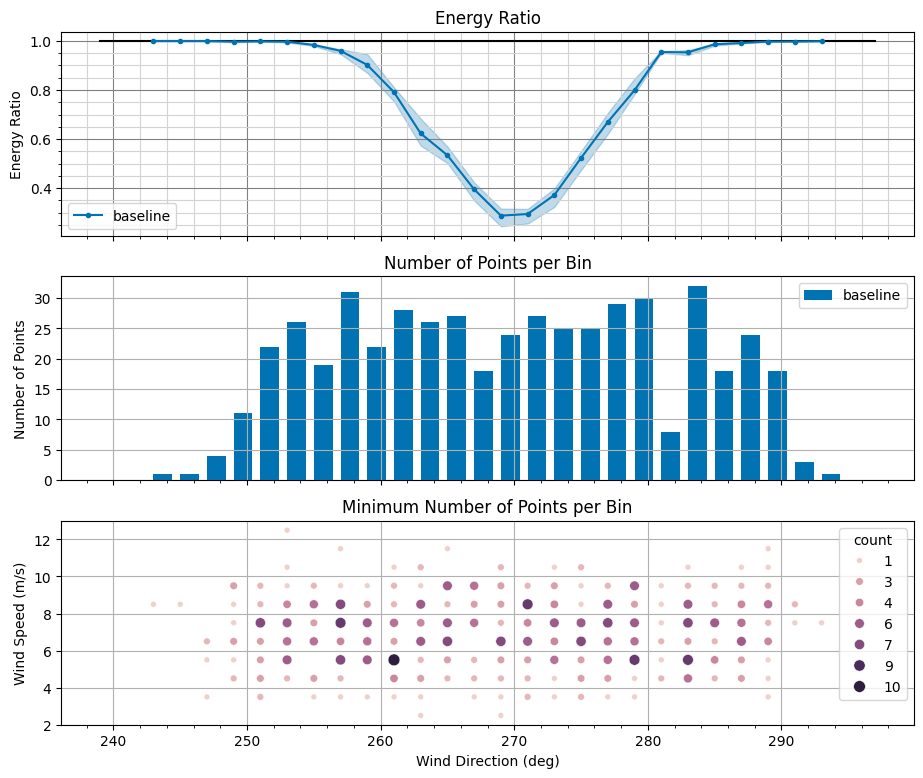

In [18]:
# Calculate and plot the energy ratio of turbine 2 with respect to
# turbine 0, using turbine 0's measurements of wind speed and wind direction
er_out = erp.compute_energy_ratio(
    er_in, test_turbines=[2], ref_turbines=[0], ws_turbines=[0], wd_turbines=[0], N=50
)
er_out.plot_energy_ratios()

array([<Axes: title={'center': 'Energy Ratio'}, ylabel='Energy Ratio'>,
       <Axes: title={'center': 'Number of Points per Bin'}, ylabel='Number of Points'>,
       <Axes: title={'center': 'Minimum Number of Points per Bin'}, xlabel='Wind Direction (deg)', ylabel='Wind Speed (m/s)'>],
      dtype=object)

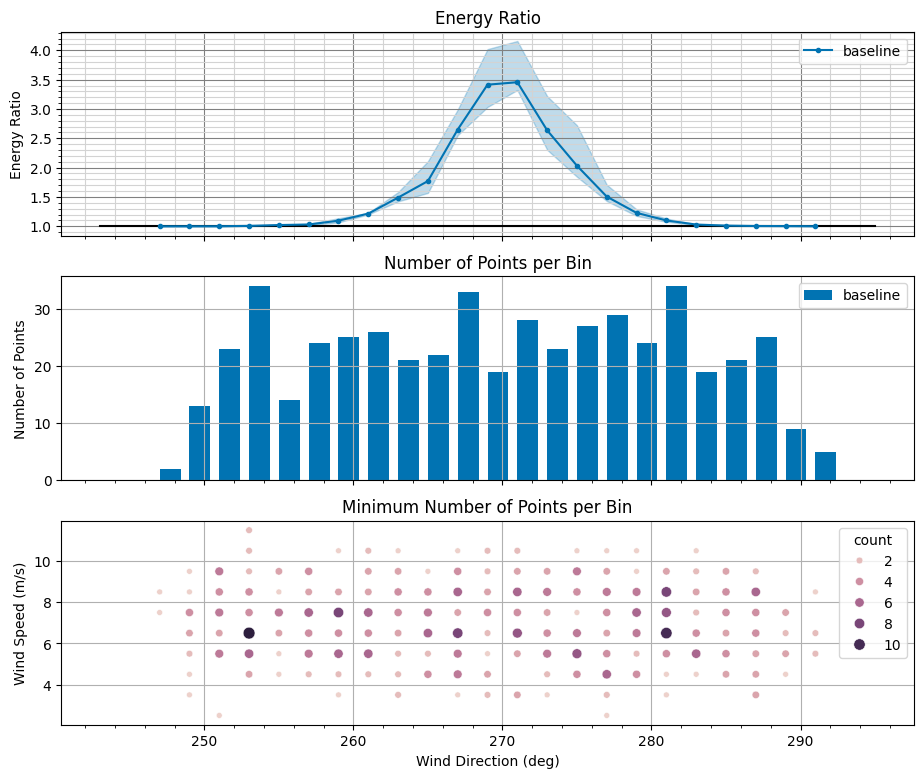

In [19]:
# Reverse the above calculation showing the energy ratio of T0 / T2,
# letting T1 supply wind speed and direction
er_out = erp.compute_energy_ratio(
    er_in, test_turbines=[0], ref_turbines=[2], ws_turbines=[1], wd_turbines=[1], N=50
)
er_out.plot_energy_ratios()

In [20]:
# Overplot the energy ratios of turbine 2 and 3, with respect to the averages of turbines 0 and 1
er_out_2 = erp.compute_energy_ratio(
    er_in, test_turbines=[2], ref_turbines=[0, 1], ws_turbines=[0, 1], wd_turbines=[0, 1], N=50
)

er_out_3 = erp.compute_energy_ratio(
    er_in, test_turbines=[3], ref_turbines=[0, 1], ws_turbines=[0, 1], wd_turbines=[0, 1], N=50
)

fig, axarr = plt.subplots(3, 1, sharex=True, figsize=(8, 11))

er_out_2.plot_energy_ratios(axarr=axarr, labels="T2")
er_out_3.plot_energy_ratios(
    axarr=axarr[0],
    show_wind_direction_distribution=False,
    show_wind_speed_distribution=False,
    labels="T3",
    color_dict={"T3": "r"},
)

<Axes: title={'center': 'Energy Ratio'}, xlabel='Wind Direction (deg)', ylabel='Energy Ratio'>

## Illustrating pre-computing reference wind speed, direction and power

In [ ]:
# Use the FLASC function for defining wind speed and direction via upstream turbines

df = dfm.set_wd_by_all_turbines(df)
df = dfm.set_ws_by_turbines(df, [0.1])
df = dfm.set_pow_ref_by_turbines(df, [0.1])

df.head()

,pow_000,pow_001,pow_002,pow_003,ws_000,ws_001,wd_000,wd_001,wd_002,wd_003,wd,ws,pow_ref
0,400.180232,400.180232,400.053966,400.171201,5.505070,5.658901,244.719564,249.045248,253.928112,249.939896,249.408340,5.505070,400.180232
1,400.180232,400.180232,400.053966,400.171201,5.128306,4.286597,247.226369,251.017923,251.599129,247.978668,249.455530,5.128306,400.180232
2,400.180232,400.180232,400.053966,400.171201,3.613740,6.381621,248.693167,250.959261,246.499915,251.836249,249.497294,3.613740,400.180232
3,400.180232,400.180232,400.053966,400.171201,4.355042,5.425659,244.401443,253.116285,249.158659,252.159534,249.710193,4.355042,400.180232
4,400.180232,400.180232,400.053966,400.171201,6.656971,4.072345,250.884149,250.705558,247.697486,249.247108,249.633627,6.656971,400.180232


array([<Axes: title={'center': 'Energy Ratio'}, ylabel='Energy Ratio'>,
       <Axes: title={'center': 'Number of Points per Bin'}, ylabel='Number of Points'>,
       <Axes: title={'center': 'Minimum Number of Points per Bin'}, xlabel='Wind Direction (deg)', ylabel='Wind Speed (m/s)'>],
      dtype=object)

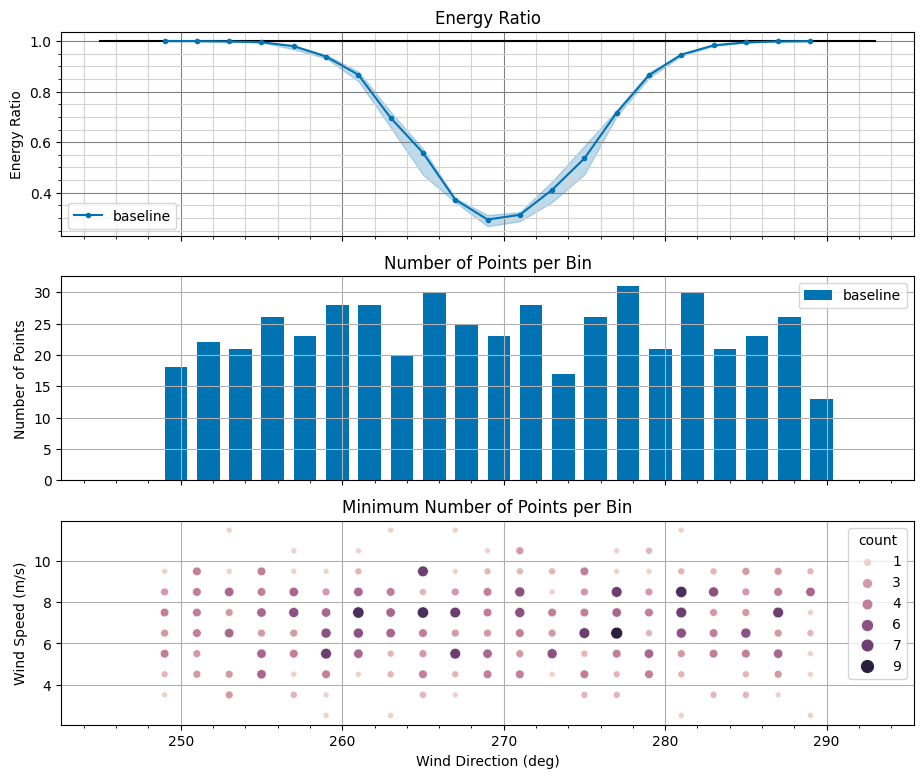

In [ ]:
# Now use the predefined values in the calculation of the average of turbines 2 and 3

er_in = EnergyRatioInput([df], ["baseline"], num_blocks=10)

er_out = erp.compute_energy_ratio(
    er_in,
    test_turbines=[2, 3],
    use_predefined_ref=True,
    use_predefined_wd=True,
    use_predefined_ws=True,
    N=50,
)
er_out.plot_energy_ratios()